<h1 align='center'>Fake News Detection</h1>

<h2>Importing Libraries And Datasets</h2>

In [1]:
!pip install tensorflow

  Using cached tensorflow-2.16.1-cp310-cp310-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp310-cp310-win_amd64.whl.metadata (5.0 kB)
Using cached tensorflow-2.16.1-cp310-cp310-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.16.1-cp310-cp310-win_amd64.whl (376.9 MB)
   ---------------------------------------- 0.0/413.4 kB ? eta -:--:--
   --------------------------------------  409.6/413.4 kB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 413.4/413.4 kB 8.6 MB/s eta 0:00:00


In [2]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy
!pip install WordCloud
!pip install gensim

In [2]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dudtl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [233]:
# 추가 데이터(크롤링, 생성)
df_true_crawling = pd.read_csv("Crawling_Timenews.csv", encoding='ISO-8859-1')
df_fake_generated = pd.read_csv("ChatGPT_3.5Turbo_generated_news_article.csv", encoding='ISO-8859-1')

<h2>Performing Exploratory Data Analysis</h2>

In [234]:
df_true_crawling['isfake'] = 0
df_true_crawling.head()

title  \
0                   Trump Blames Everything But Guns   
1  Trump Suggests Deal for Background Checks, Imm...   
2  Beto O'Rourke Halts Campaign to Return to El Paso   
3  Ilhan Omar Trolls Trump With Pictures From Afr...   
4  A Marianne Williamson Supporter Instructed a C...   

                                                text       subject  \
0  President Donald Trump called for a crackdown ...  politicsNews   
1  President Donald Trump on Monday suggested Con...  politicsNews   
2  2020 Democratic presidential candidate Beto O_...  politicsNews   
3  Congresswoman Ilhan Omar responded Thursday to...  politicsNews   
4  In what is certainly one of the more confusing...  politicsNews   

                                     date  isfake  
0                By Tessa Berenson Rogers       0  
1                         By Ciara Nugent       0  
2                         By Josiah Bates       0  
3            By Amy Gunia  August 2, 2019       0  
4  By Rachel E. Greenspan  August 1, 2019       0

In [235]:
df_fake_generated['isfake'] = 1
df_fake_generated.head()

title  \
0  "From the Frontlines to the Campaign Trail: Ma...   
1  "Trump Urges Fed to Avoid 'Repeat Offender' St...   
2  "Comey's Fury: Former FBI Director Unleashes C...   
3  "From One First Lady to Another: Michelle Obam...   
4  "North Korea Defiant: U.S. Sanctions and Press...   

                                                text       subject      date  \
0  As the 2020 election season approaches, Arizon...  politicsNews  2024.6.8   
1  In a recent tweet, President Donald Trump once...  politicsNews  2024.6.8   
2  In a shocking turn of events, former FBI Direc...  politicsNews  2024.6.8   
3  Former First Lady Michelle Obama recently made...  politicsNews  2024.6.8   
4  In the midst of escalating tensions between th...  politicsNews  2024.6.8   

   isfake  
0       1  
1       1  
2       1  
3       1  
4       1

In [236]:
# Concatenating Real And Fake News
df = pd.concat([df_true_crawling, df_fake_generated]).reset_index(drop = True)
df = df.dropna(subset=['title'])
df

title  \
0                       Trump Blames Everything But Guns   
1      Trump Suggests Deal for Background Checks, Imm...   
2      Beto O'Rourke Halts Campaign to Return to El Paso   
3      Ilhan Omar Trolls Trump With Pictures From Afr...   
4      A Marianne Williamson Supporter Instructed a C...   
...                                                  ...   
11138  "Is Wisconsin Turning Blue? The Surprising Rea...   
11139  "Clinton Remains Calm as FBI Investigation Loo...   
11140  "GOP Chair Sounds Alarm: 'No One is Above the ...   
11141  "Trump Admits Fault: Tweet About Cruz's Wife W...   
11142  "Unleashing the Fireworks: The Epic Showdown a...   

                                                    text  \
0      President Donald Trump called for a crackdown ...   
1      President Donald Trump on Monday suggested Con...   
2      2020 Democratic presidential candidate Beto O_...   
3      Congresswoman Ilhan Omar responded Thursday to...   
4      In what is certainly one of the more confusing...   
...                                                  ...   
11138  In the 2016 presidential election, Wisconsin w...   
11139  Washington D.C. - After months of speculation,...   
11140  Washington D.C. - The Republican Party is faci...   
11141  In a surprising turn of events, President Dona...   
11142  The stage is set for an epic showdown at "The ...   

                                                 subject  \
0                                           politicsNews   
1                                           politicsNews   
2                                           politicsNews   
3                                           politicsNews   
4                                           politicsNews   
...                                                  ...   
11138                     Why Trump Could Lose Wisconsin   
11139  Hillary Clinton Says FBI Has Not Yet Contacted...   
11140        GOP Chair Warns of 'Consequences' for Trump   
11141  Trump Says Tweet About Cruz_ Wife Was a 'Mistake'   
11142                            The Great Debate Debate   

                                         date  isfake  
0                    By Tessa Berenson Rogers       0  
1                             By Ciara Nugent       0  
2                             By Josiah Bates       0  
3                By Amy Gunia  August 2, 2019       0  
4      By Rachel E. Greenspan  August 1, 2019       0  
...                                       ...     ...  
11138                                2024.6.8       1  
11139                                2024.6.8       1  
11140                                2024.6.8       1  
11141                                2024.6.8       1  
11142                                2024.6.8       1  

[11133 rows x 5 columns]

In [237]:
df.drop(columns = ['date'], inplace = True)

In [238]:
# Combining Title And Text Together
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0                   Trump Blames Everything But Guns   
1  Trump Suggests Deal for Background Checks, Imm...   
2  Beto O'Rourke Halts Campaign to Return to El Paso   
3  Ilhan Omar Trolls Trump With Pictures From Afr...   
4  A Marianne Williamson Supporter Instructed a C...   

                                                text       subject  isfake  \
0  President Donald Trump called for a crackdown ...  politicsNews       0   
1  President Donald Trump on Monday suggested Con...  politicsNews       0   
2  2020 Democratic presidential candidate Beto O_...  politicsNews       0   
3  Congresswoman Ilhan Omar responded Thursday to...  politicsNews       0   
4  In what is certainly one of the more confusing...  politicsNews       0   

                                            original  
0  Trump Blames Everything But Guns President Don...  
1  Trump Suggests Deal for Background Checks, Imm...  
2  Beto O'Rourke Halts Campaign to Return to El P...  
3  Ilhan Omar Trolls Trump With Pictures From Afr...  
4  A Marianne Williamson Supporter Instructed a C...

In [240]:
df['original'][10000]

'"Republicans Strike Back: Party Condemns Trump\'s \'Rigged\' Claims as Election Looms" Washington D.C. - As the highly anticipated 2020 presidential election approaches, tensions between President Donald Trump and the Republican Party have reached a boiling point. In a recent tweet, Trump declared that the upcoming election is "rigged" and suggested that he may not accept the results if he does not win. In response, the Republican Party has issued a statement condemning Trump\'s remarks and distancing themselves from his claims.\n\nThe background of this issue dates back to the 2016 presidential election, where Trump\'s victory was met with accusations of Russian interference and claims of a rigged election. Despite these allegations, Trump has consistently denied any wrongdoing and has often used the phrase "rigged" to describe any unfavorable outcome.\n\nHowever, with the 2020 election rapidly approaching, Trump\'s repeated use of this term has sparked concern within the Republican 

<h2>Performing Data Cleaning</h2>

In [241]:
# Downloading Stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dudtl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [242]:
# Obtaining Additional Stopwords From nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

기본 모델 전처리

In [243]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [244]:
# Applying The Function To The Dataframe
df['clean_original'] = df['original'].apply(preprocess)

In [245]:
# Joining The Words Into A String
df['clean_original_joined'] = df['clean_original'].apply(lambda x: " ".join(x))

lemmatization 추가한 전처리

In [246]:
# Removing Stopwords And Remove Words With 2 Or Less Characters
import gensim
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

def preprocess_lem(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            lemmatized_token = lemma.lemmatize(token)  # 표제어 추출
            result.append(lemmatized_token)
            
    return result

In [247]:
# Applying The Function To The Dataframe
df['clean'] = df['original'].apply(preprocess_lem)

In [260]:
# Joining The Words Into A String
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [248]:
# Showing Original News
df['original'][0]

'Trump Blames Everything But Guns President Donald Trump called for a crackdown on violent video games and reforms to mental health laws, arguing that _ental illness and hatred pulls the trigger, not the gun, in a speech from the White House after mass shootings in El Paso, Texas, and Dayton, Ohio. Trump_ comments came after two mass shootings rocked the nation over a span of less than 24 hours. Twenty-two people were killed in a shooting at a Walmart in El Paso, Texas, on Saturday and nine victims were fatally shot in Dayton, Ohio, early on Sunday. According to authorities, the El Paso shooting suspect may have posted a manifesto online before the attack filled with anti-immigrant sentiment. Trump called the shooter a _icked man and offered condolences to the people of Mexico in his remarks; some of the victims were Mexican nationals. _n one voice, our nation must condemn racism, bigotry and white supremacy, Trump said, with Vice President Mike Pence standing beside him, in the Diplom

In [250]:
# Showing Cleaned Up News After Removing Stopwords
print(df['clean_original'][0])

['trump', 'blames', 'guns', 'president', 'donald', 'trump', 'called', 'crackdown', 'violent', 'video', 'games', 'reforms', 'mental', 'health', 'laws', 'arguing', 'illness', 'hatred', 'pulls', 'trigger', 'speech', 'white', 'house', 'mass', 'shootings', 'paso', 'texas', 'dayton', 'ohio', 'trump_', 'comments', 'came', 'mass', 'shootings', 'rocked', 'nation', 'span', 'hours', 'people', 'killed', 'shooting', 'walmart', 'paso', 'texas', 'saturday', 'victims', 'fatally', 'shot', 'dayton', 'ohio', 'early', 'sunday', 'according', 'authorities', 'paso', 'shooting', 'suspect', 'posted', 'manifesto', 'online', 'attack', 'filled', 'anti', 'immigrant', 'sentiment', 'trump', 'called', 'shooter', 'offered', 'condolences', 'people', 'mexico', 'remarks', 'victims', 'mexican', 'nationals', 'voice', 'nation', 'condemn', 'racism', 'bigotry', 'white', 'supremacy', 'trump', 'said', 'vice', 'president', 'mike', 'pence', 'standing', 'diplomatic', 'room', 'white', 'house', 'sinister', 'ideologies', 'defeated', 

In [251]:
# Showing Cleaned Up News After Removing Stopwords
print(df['clean'][0])

['trump', 'blame', 'gun', 'president', 'donald', 'trump', 'called', 'crackdown', 'violent', 'video', 'game', 'reform', 'mental', 'health', 'law', 'arguing', 'illness', 'hatred', 'pull', 'trigger', 'speech', 'white', 'house', 'mass', 'shooting', 'paso', 'texas', 'dayton', 'ohio', 'trump_', 'comment', 'came', 'mass', 'shooting', 'rocked', 'nation', 'span', 'hour', 'people', 'killed', 'shooting', 'walmart', 'paso', 'texas', 'saturday', 'victim', 'fatally', 'shot', 'dayton', 'ohio', 'early', 'sunday', 'according', 'authority', 'paso', 'shooting', 'suspect', 'posted', 'manifesto', 'online', 'attack', 'filled', 'anti', 'immigrant', 'sentiment', 'trump', 'called', 'shooter', 'offered', 'condolence', 'people', 'mexico', 'remark', 'victim', 'mexican', 'national', 'voice', 'nation', 'condemn', 'racism', 'bigotry', 'white', 'supremacy', 'trump', 'said', 'vice', 'president', 'mike', 'penny', 'standing', 'diplomatic', 'room', 'white', 'house', 'sinister', 'ideology', 'defeated', 'hate', 'place', 'a

In [261]:
df

title  \
0                       Trump Blames Everything But Guns   
1      Trump Suggests Deal for Background Checks, Imm...   
2      Beto O'Rourke Halts Campaign to Return to El Paso   
3      Ilhan Omar Trolls Trump With Pictures From Afr...   
4      A Marianne Williamson Supporter Instructed a C...   
...                                                  ...   
11138  "Is Wisconsin Turning Blue? The Surprising Rea...   
11139  "Clinton Remains Calm as FBI Investigation Loo...   
11140  "GOP Chair Sounds Alarm: 'No One is Above the ...   
11141  "Trump Admits Fault: Tweet About Cruz's Wife W...   
11142  "Unleashing the Fireworks: The Epic Showdown a...   

                                                    text  \
0      President Donald Trump called for a crackdown ...   
1      President Donald Trump on Monday suggested Con...   
2      2020 Democratic presidential candidate Beto O_...   
3      Congresswoman Ilhan Omar responded Thursday to...   
4      In what is certainly one of the more confusing...   
...                                                  ...   
11138  In the 2016 presidential election, Wisconsin w...   
11139  Washington D.C. - After months of speculation,...   
11140  Washington D.C. - The Republican Party is faci...   
11141  In a surprising turn of events, President Dona...   
11142  The stage is set for an epic showdown at "The ...   

                                                 subject  isfake  \
0                                           politicsNews       0   
1                                           politicsNews       0   
2                                           politicsNews       0   
3                                           politicsNews       0   
4                                           politicsNews       0   
...                                                  ...     ...   
11138                     Why Trump Could Lose Wisconsin       1   
11139  Hillary Clinton Says FBI Has Not Yet Contacted...       1   
11140        GOP Chair Warns of 'Consequences' for Trump       1   
11141  Trump Says Tweet About Cruz_ Wife Was a 'Mistake'       1   
11142                            The Great Debate Debate       1   

                                                original  \
0      Trump Blames Everything But Guns President Don...   
1      Trump Suggests Deal for Background Checks, Imm...   
2      Beto O'Rourke Halts Campaign to Return to El P...   
3      Ilhan Omar Trolls Trump With Pictures From Afr...   
4      A Marianne Williamson Supporter Instructed a C...   
...                                                  ...   
11138  "Is Wisconsin Turning Blue? The Surprising Rea...   
11139  "Clinton Remains Calm as FBI Investigation Loo...   
11140  "GOP Chair Sounds Alarm: 'No One is Above the ...   
11141  "Trump Admits Fault: Tweet About Cruz's Wife W...   
11142  "Unleashing the Fireworks: The Epic Showdown a...   

                                          clean_original  \
0      [trump, blames, guns, president, donald, trump...   
1      [trump, suggests, deal, background, checks, im...   
2      [beto, rourke, halts, campaign, return, paso, ...   
3      [ilhan, omar, trolls, trump, pictures, africa,...   
4      [marianne, williamson, supporter, instructed, ...   
...                                                  ...   
11138  [wisconsin, turning, blue, surprising, reasons...   
11139  [clinton, remains, calm, investigation, looms,...   
11140  [chair, sounds, alarm, trump, faces, potential...   
11141  [trump, admits, fault, tweet, cruz, wife, mist...   
11142  [unleashing, fireworks, epic, showdown, great,...   

                                   clean_original_joined  \
0      trump blames guns president donald trump calle...   
1      trump suggests deal background checks immigrat...   
2      beto rourke halts campaign return paso democra...   
3      ilhan omar trolls trump pictures africa visit ...   
4      marianne williamson supporter instructed st

In [253]:
# Obtaining The Total Words Present In The Dataset
list_of_words_original = []
for i in df.clean_original:
    for j in i:
        list_of_words_original.append(j)

In [255]:
# Obtaining The Total Words Present In The Dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [256]:
len(list_of_words_original)

2505300

In [89]:
len(list_of_words)

2505300

In [258]:
# Obtaining The Total Number Of Unique Words
total_words_original = len(list(set(list_of_words_original)))
total_words_original

39079

In [259]:
# Obtaining The Total Number Of Unique Words
total_words= len(list(set(list_of_words)))
total_words

35091

<h2>Visualizing Cleaned Up Dataset</h2>

<Axes: xlabel='count', ylabel='isfake'>

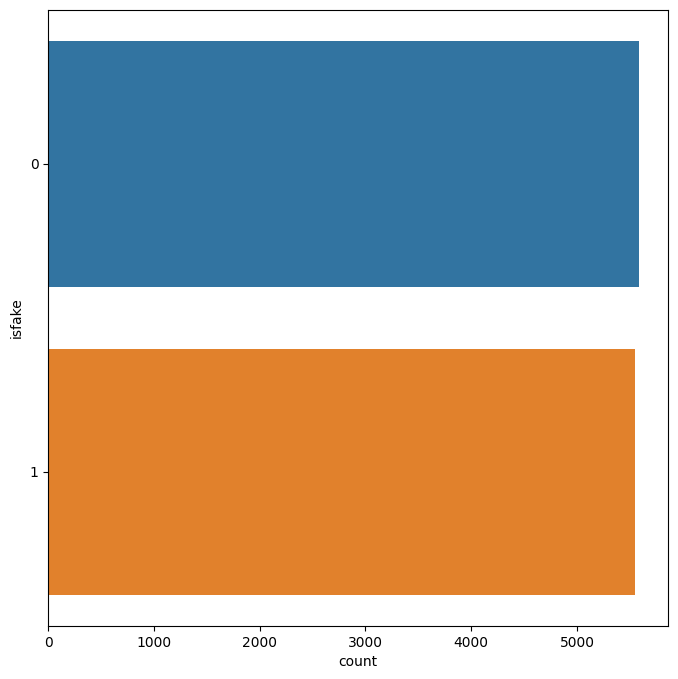

In [264]:
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

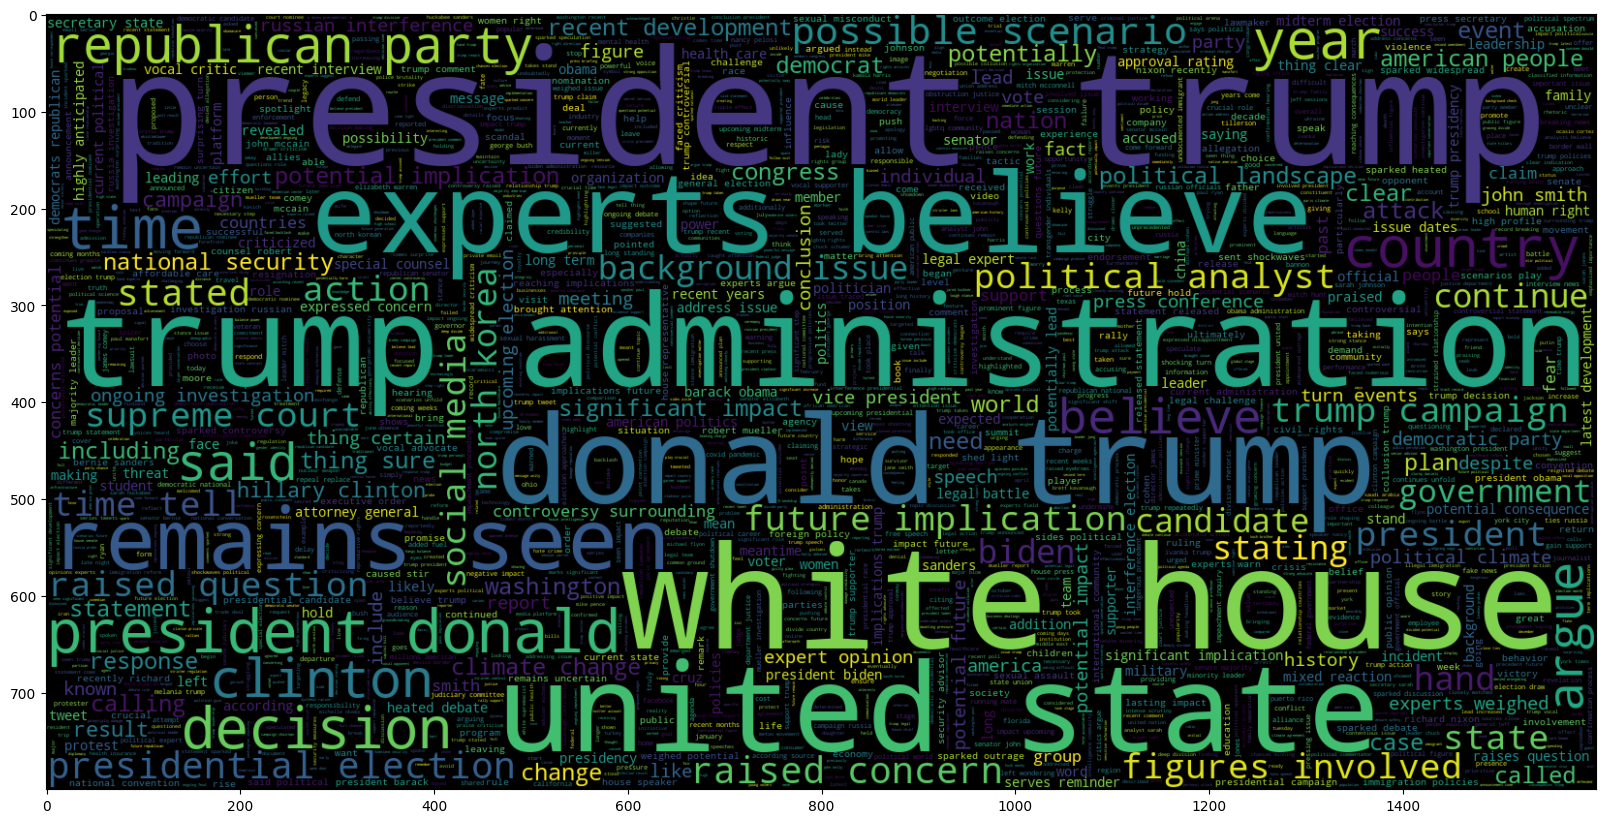

In [265]:
# Plotting The Word Cloud For Text That Is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_original_joined))
plt.imshow(wc, interpolation = 'bilinear')

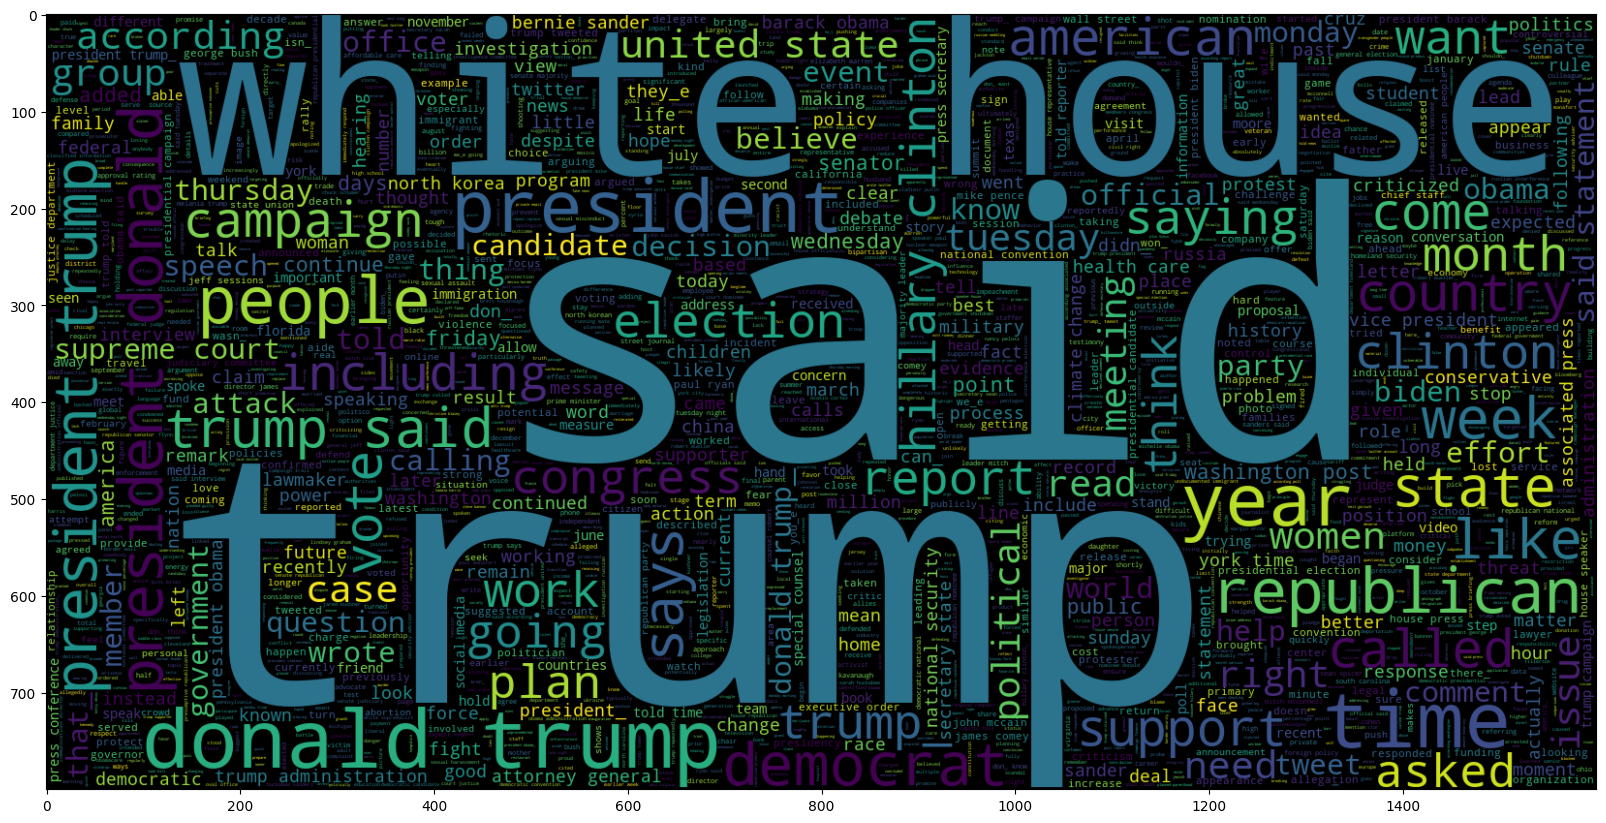

In [266]:
# Plotting The Word Cloud For Text That Is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_original_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [269]:
# Determining The Maximum Number Of Words In Any Document Required To Create Word Embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 1209


In [270]:
# Visualizing The Distribution Of Number Of Words In A Text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

<h2>Preparing The Data By Performing Tokenization And Padding</h2>

기본 모델

In [286]:
# Splitting Data Into Test And Train 
import random
import os
from sklearn.model_selection import train_test_split
from nltk import word_tokenize

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_original_joined, df.isfake, test_size = 0.2, random_state=42)

# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words_original)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Adding Padding
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

# Sequential Model
model = Sequential()
vector_dim = 100
max_len = 40
# Embeddidng layer
model.add(Embedding(total_words_original, output_dim = vector_dim, input_length=max_len))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.build(input_shape=(None, max_len))
model.summary()

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

c:\Users\dudtl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)        │ (None, 40, 100)        │     3,907,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_49                │ (None, 256)            │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,175,421 (15.93 MB)

 Trainable params: 4,175,421 (15.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - acc: 0.8256 - loss: 0.3860 - val_acc: 0.9540 - val_loss: 0.1185
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - acc: 0.9847 - loss: 0.0448 - val_acc: 0.9484 - val_loss: 0.1736
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - acc: 0.9979 - loss: 0.0069 - val_acc: 0.9428 - val_loss: 0.1767
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - acc: 0.9994 - loss: 0.0023 - val_acc: 0.9461 - val_loss: 0.2260
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - acc: 0.9998 - loss: 0.0014 - val_acc: 0.9405 - val_loss: 0.2324
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Model Accuracy :  0.9582397844634036
True Positives (TP): 1042
False Positives (FP): 31


Functional API로 모델 정의 + Keras의 attention 레이어 사용

In [287]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Attention, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from sklearn.metrics import classification_report, accuracy_score

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_original_joined, df.isfake, test_size = 0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000) # 어휘 사전 크기 설정
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# 시퀀스 패딩
max_sequence_length = 40  # 시퀀스 길이 설정
padded_train = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_sequence_length, truncating='post')

vector_dim = 100

# 모델 정의 (Functional API 사용)
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=20000, output_dim=vector_dim, input_length=max_sequence_length)(input_layer)
bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
attention_layer = Attention()([bilstm_layer, bilstm_layer])

# 어텐션 결과를 풀링
average_pooling = GlobalAveragePooling1D()(attention_layer)
max_pooling = GlobalMaxPooling1D()(attention_layer)
concatenated = Concatenate()([average_pooling, max_pooling])

# Dense 레이어
dense_layer = Dense(128, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# 모델 정의
model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 모델 요약 출력
model.summary()

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")


c:\Users\dudtl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_51        │ (None, 40, 100)   │  2,000,000 │ input_layer_51[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_50    │ (None, 40, 256)   │    234,496 │ embedding_51[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_16        │ (None, 40, 256)   │          0 │ bidirectional_50… │
│ (Attention)         │                   │            │ bidirectional_50… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_16[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention_16[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_148 (Dense)   │ (None, 128)       │     65,664 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_149 (Dense)   │ (None, 1)         │        129 │ dense_148[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,300,289 (8.77 MB)

 Trainable params: 2,300,289 (8.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - acc: 0.8381 - loss: 0.3629 - val_acc: 0.9529 - val_loss: 0.1174
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - acc: 0.9869 - loss: 0.0376 - val_acc: 0.9439 - val_loss: 0.1413
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - acc: 0.9976 - loss: 0.0068 - val_acc: 0.9428 - val_loss: 0.1619
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - acc: 0.9986 - loss: 0.0051 - val_acc: 0.9405 - val_loss: 0.1768
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - acc: 1.0000 - loss: 5.1507e-04 - val_acc: 0.9506 - val_loss: 0.2563
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
Model Accuracy :  0.9609339919173776
True Positives (TP): 1042
False Positives (FP): 25


Sequential API로 모델 정의 + 직접 정의한 SelfAttention 클래스 사용

In [288]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Layer, Flatten
from sklearn.metrics import classification_report, accuracy_score

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_original_joined, df.isfake, test_size = 0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000) # 어휘 사전 크기 설정
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# 시퀀스 패딩
max_len = 40  # 시퀀스 길이 설정
padded_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_len, truncating='post')

# Self-Attention 레이어 정의
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.query_dense = Dense(units)
        self.key_dense = Dense(units)
        self.value_dense = Dense(units)
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    
    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        attention_score = tf.matmul(query, key, transpose_b=True)
        attention_weights = self.softmax(attention_score)
        context_vector = tf.matmul(attention_weights, value)
        
        return context_vector

# LSTM 모델 정의
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=100, input_length=max_len))  # 랜덤 초기화된 임베딩
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(SelfAttention(128))
model.add(Flatten())  # 출력 형태를 2D로 만듦
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
        
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

Epoch 1/5


c:\Users\dudtl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 175ms/step - accuracy: 0.8484 - loss: 0.3234 - val_accuracy: 0.9517 - val_loss: 0.1194
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9888 - loss: 0.0278 - val_accuracy: 0.9439 - val_loss: 0.3583
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.9957 - loss: 0.0163 - val_accuracy: 0.9439 - val_loss: 0.2214
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9484 - val_loss: 0.2005
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9473 - val_loss: 0.3177
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
Model Accuracy :  0.9461158509205209
True Positives (TP): 1037
False Positives (FP): 53


Functional API로 모델 정의 + Keras의 attention 레이어 사용 + 전처리

In [290]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Attention, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from sklearn.metrics import classification_report, accuracy_score

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size=0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000) # 어휘 사전 크기 설정
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# 시퀀스 패딩
max_sequence_length = 40  # 시퀀스 길이 설정
padded_train = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_sequence_length, truncating='post')

# GloVe 벡터 로드 및 임베딩 매트릭스 생성
def load_glove_vectors(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_to_vec = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vec[word] = vector
    return word_to_vec

# GloVe 벡터 파일 경로 설정 (다운로드한 GloVe 파일)
glove_file = 'glove.6B.100d.txt'  # 100차원 벡터 파일 예시
word_to_vec = load_glove_vectors(glove_file)
vector_dim = 100

embedding_matrix = np.zeros((20000, vector_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < 20000:
        vector = word_to_vec.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# 모델 정의 (Functional API 사용)
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=20000, output_dim=vector_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)(input_layer)
bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
attention_layer = Attention()([bilstm_layer, bilstm_layer])

# 어텐션 결과를 풀링
average_pooling = GlobalAveragePooling1D()(attention_layer)
max_pooling = GlobalMaxPooling1D()(attention_layer)
concatenated = Concatenate()([average_pooling, max_pooling])

# Dense 레이어
dense_layer = Dense(128, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# 모델 정의
model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 모델 요약 출력
model.summary()

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
        
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_54      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_54        │ (None, 40, 100)   │  2,000,000 │ input_layer_54[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_52    │ (None, 40, 256)   │    234,496 │ embedding_54[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_17        │ (None, 40, 256)   │          0 │ bidirectional_52… │
│ (Attention)         │                   │            │ bidirectional_52… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_17[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention_17[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_155 (Dense)   │ (None, 128)       │     65,664 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_156 (Dense)   │ (None, 1)         │        129 │ dense_155[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,300,289 (8.77 MB)

 Trainable params: 300,289 (1.15 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - acc: 0.7639 - loss: 0.4584 - val_acc: 0.9282 - val_loss: 0.1665
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - acc: 0.9266 - loss: 0.1844 - val_acc: 0.9506 - val_loss: 0.1299
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - acc: 0.9569 - loss: 0.1143 - val_acc: 0.9315 - val_loss: 0.2017
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - acc: 0.9585 - loss: 0.1045 - val_acc: 0.9338 - val_loss: 0.1714
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - acc: 0.9731 - loss: 0.0671 - val_acc: 0.9315 - val_loss: 0.2076
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Model Accuracy :  0.8446340368208352
True Positives (TP): 759
False Positives (FP): 1


Sequential API로 모델 정의 + 직접 정의한 SelfAttention 클래스 사용 + 전처리

In [292]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Layer, Flatten

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 텍스트 데이터와 라벨 분리
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size=0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000) # 어휘 사전 크기 설정
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# 시퀀스 패딩
max_len = 40  # 시퀀스 길이 설정
padded_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_len, truncating='post')

# GloVe 벡터 로드 및 임베딩 매트릭스 생성
def load_glove_vectors(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_to_vec = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vec[word] = vector
    return word_to_vec

# GloVe 벡터 파일 경로 설정 (다운로드한 GloVe 파일)
glove_file = 'glove.6B.100d.txt'  # 100차원 벡터 파일 예시
word_to_vec = load_glove_vectors(glove_file)
vector_dim = 100

embedding_matrix = np.zeros((20000, vector_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < 20000:
        vector = word_to_vec.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Self-Attention 레이어 정의
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.query_dense = Dense(units)
        self.key_dense = Dense(units)
        self.value_dense = Dense(units)
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    
    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        attention_score = tf.matmul(query, key, transpose_b=True)
        attention_weights = self.softmax(attention_score)
        context_vector = tf.matmul(attention_weights, value)
        
        return context_vector

# LSTM 모델 정의
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=vector_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(SelfAttention(128))
model.add(Flatten())  # 출력 형태를 2D로 만듦
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

# Making prediction
pred = model.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
        
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
conf_matrix = confusion_matrix(list(y_test), prediction)

# confusion_matrix returns [ [TN, FP], [FN, TP] ]
TN, FP, FN, TP = conf_matrix.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.7501 - loss: 0.5051 - val_accuracy: 0.9057 - val_loss: 0.2183
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.8991 - loss: 0.2459 - val_accuracy: 0.9136 - val_loss: 0.2182
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.9428 - loss: 0.1533 - val_accuracy: 0.9304 - val_loss: 0.1814
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9578 - loss: 0.1087 - val_accuracy: 0.9282 - val_loss: 0.1901
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.9610 - loss: 0.0934 - val_accuracy: 0.9473 - val_loss: 0.1601
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
Model Accuracy :  0.9263583295913785
True Positives (TP): 960
False Positives (FP): 20
